<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/Knowledge-Distillation/blob/main/GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install torch torchvision torchaudio torch-geometric networkx scipy numpy opencv-python matplotlib


In [45]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os
import cv2
import numpy as np
import networkx as nx
from scipy.spatial import Delaunay
import torch
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn.functional as F
import torch.optim as optim

In [47]:
# Define dataset path in Google Drive
dataset_path = "/content/drive/MyDrive/Dataset4"

In [48]:
# Function to convert image to graph using ORB + Delaunay Triangulation
def computeORBGraph(image):
    """
    Extracts keypoints from an image using ORB and constructs a graph representation.
    Nodes represent keypoints, and edges are formed using Delaunay Triangulation.
    """
    orb = cv2.ORB_create(nfeatures=700, scaleFactor=1.2, nlevels=8, edgeThreshold=15)
    keypoints, descriptors = orb.detectAndCompute(image, None)

    if not keypoints or descriptors is None:
        return None, None, None  # No keypoints detected

    points = np.array([kp.pt for kp in keypoints], dtype=np.float32)
    G = nx.Graph()

    # Add nodes with descriptors
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y), descriptor=descriptors[i])

    # Create edges using Delaunay Triangulation
    if len(points) > 2:
        tri = Delaunay(points)
        for simplex in tri.simplices:
            for i in range(3):
                G.add_edge(simplex[i], simplex[(i+1) % 3])

    return G, keypoints, descriptors


In [49]:
# Custom PyTorch Geometric Dataset for Currency Notes
class CurrencyGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        self.data_list = [] # Initialize data_list here, before calling super().__init__
        super().__init__(root, transform, pre_transform)
        self.process()

    @property
    def processed_file_names(self):
        """
        Returns a list of filenames that represent the processed dataset.
        This is required by the PyTorch Geometric Dataset class to check if the
        data has already been processed.
        """
        return ['data.pt']  # You can change this to a more descriptive name or a list of files if needed.

    def process(self):
        for label, folder in enumerate(['Real', 'Fake']):
            folder_path = os.path.join(dataset_path, 'Training', folder)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                G, keypoints, descriptors = computeORBGraph(image)
                if G is None:
                    continue

                # Convert graph to PyTorch Geometric format
                edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
                x = torch.tensor(np.array([G.nodes[i]['descriptor'] for i in G.nodes]), dtype=torch.float)
                y = torch.tensor([label], dtype=torch.long)  # Graph-level label

                data = Data(x=x, edge_index=edge_index, y=y)
                self.data_list.append(data)

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [50]:
# Load dataset
dataset = CurrencyGraphDataset(root=dataset_path)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Loaded {len(dataset)} graphs.")

Processing...
Done!


Loaded 128 graphs.


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [51]:
from torch_geometric.nn import GATConv

# Define the GAT model
class GATClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2, heads=2):
        super(GATClassifier, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)  # Graph-level pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Get feature dimension from dataset
input_dim = dataset[0].x.shape[1]

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATClassifier(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.NLLLoss()


Epoch 1/50, Loss: 102.6444
Epoch 2/50, Loss: 40.4866
Epoch 3/50, Loss: 41.3983
Epoch 4/50, Loss: 33.8622
Epoch 5/50, Loss: 33.0971
Epoch 6/50, Loss: 38.4504
Epoch 7/50, Loss: 35.3178
Epoch 8/50, Loss: 29.1559
Epoch 9/50, Loss: 24.7340
Epoch 10/50, Loss: 23.0316
Epoch 11/50, Loss: 21.4644
Epoch 12/50, Loss: 25.7328
Epoch 13/50, Loss: 19.3428
Epoch 14/50, Loss: 20.2049
Epoch 15/50, Loss: 17.0137
Epoch 16/50, Loss: 17.4923
Epoch 17/50, Loss: 16.7305
Epoch 18/50, Loss: 15.2665
Epoch 19/50, Loss: 19.8465
Epoch 20/50, Loss: 15.0814
Epoch 21/50, Loss: 15.1261
Epoch 22/50, Loss: 13.8191
Epoch 23/50, Loss: 11.8595
Epoch 24/50, Loss: 15.4260
Epoch 25/50, Loss: 12.9090
Epoch 26/50, Loss: 15.5658
Epoch 27/50, Loss: 13.2690
Epoch 28/50, Loss: 15.1946
Epoch 29/50, Loss: 11.0182
Epoch 30/50, Loss: 11.0398
Epoch 31/50, Loss: 14.1112
Epoch 32/50, Loss: 12.5734
Epoch 33/50, Loss: 12.5661
Epoch 34/50, Loss: 12.3084
Epoch 35/50, Loss: 14.8332
Epoch 36/50, Loss: 17.4537
Epoch 37/50, Loss: 16.6663
Epoch 38/

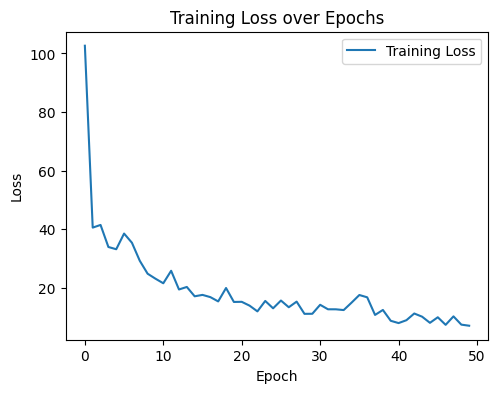

In [52]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, optimizer, criterion, epochs=50):
    model.train()
    epoch_losses = []  # Store loss for each epoch


    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_losses.append(total_loss)


        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    # Plotting
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


# Call the modified train_model function
train_model(model, train_loader, optimizer, criterion, epochs=50)

In [53]:
# def evaluate(model, test_loader):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for data in test_loader:
#             data = data.to(device)
#             out = model(data)
#             pred = out.argmax(dim=1)
#             all_preds.extend(pred.cpu().numpy())
#             all_labels.extend(data.y.cpu().numpy())

#     # ... (rest of your evaluation metrics calculation) ...

#     # Generate and display confusion matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.title("Confusion Matrix")
#     plt.show()

#     return accuracy
# # Load test dataset
# test_dataset_path = os.path.join(dataset_path, 'Testing') # Assuming your test data is in a 'Testing' subfolder
# test_dataset = CurrencyGraphDataset(root=test_dataset_path)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)  # You might not want to shuffle test data

# # ... (your existing evaluate function code) ...


# # Evaluate the model and display the confusion matrix
# accuracy = evaluate(model, test_loader)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test F1-score: {f1:.4f}")

    return accuracy

# ... (rest of your code) ...

# Load test dataset
test_dataset_path = os.path.join(dataset_path, 'Testing')
test_dataset = CurrencyGraphDataset(root=test_dataset_path)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

accuracy = evaluate(model, test_loader)

Processing...
Done!


Test Accuracy: 93.75%
Test Precision: 0.9118
Test F1-score: 0.9394


In [61]:
import os
import cv2
import torch
from torch_geometric.data import Data

# Load a sample image
sample_image_path = '/content/drive/MyDrive/Dataset4/Training/Real/500_s1.jpg'  # Replace with the path to your sample image
image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image and create the graph
G, keypoints, descriptors = computeORBGraph(image)

if G is None:
    print("No keypoints detected in the sample image.")
else:
    # Convert graph to PyTorch Geometric format
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(np.array([G.nodes[i]['descriptor'] for i in G.nodes]), dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)

    # Move data to the appropriate device (GPU if available)
    data = data.to(device)

    # Make prediction with the trained model
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1).item()

    # Interpret the prediction
    if pred == 0:
        prediction_label = "Real"
    else:
        prediction_label = "Fake"

    print(f"Prediction for sample image: {prediction_label}")

Prediction for sample image: Real


In [56]:
# Save the model's state_dict
torch.save(model.state_dict(), '/content/drive/MyDrive/gat_model.pth')


In [63]:
import os
import torch
import cv2
import numpy as np
# from torch_geometric.data import Data
# from gat import computeORBGraph, GATClassifier  # Make sure to import from your GAT file

# Set paths
trained_model_path = '/content/drive/MyDrive/gat_model.pth'
dataset_train_path = '/content/drive/MyDrive/Dataset4/Training'

# Load trained GAT teacher
input_dim = 32  # ORB descriptor size (double-check if yours is 32 or 64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = GATClassifier(input_dim=input_dim).to(device)
teacher_model.load_state_dict(torch.load(trained_model_path, map_location=device))
teacher_model.eval()

teacher_logits = {}

# Iterate through all training images
for label_folder in ['Real', 'Fake']:
    folder_path = os.path.join(dataset_train_path, label_folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        G, keypoints, descriptors = computeORBGraph(image)
        if G is None:
            continue

        edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
        x = torch.tensor(np.array([G.nodes[i]['descriptor'] for i in G.nodes]), dtype=torch.float)

        data = Data(x=x, edge_index=edge_index).to(device)

        with torch.no_grad():
            output = teacher_model(data)  # output shape: (1, 2)

        logits = output.squeeze().cpu()  # shape: (2,)
        teacher_logits[img_path] = logits

# Save teacher logits to file
torch.save(teacher_logits, '/content/drive/MyDrive/teacher_logits.pt')
print("Teacher logits saved successfully!")


Teacher logits saved successfully!
